<a href="https://colab.research.google.com/github/vascomedici/teaching_project_scc/blob/main/pv_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. PV plant simulator
This first example is a **simple PV plant simulator**, which simulates the output of an unshaded PV plant, starting from a location and a weather file that contains T and GHI. We will use the [pvlib library](https://pvlib-python.readthedocs.io/) to help us with some calculations. This is a very powerful PV simulation library that can be used to simulate PV plants in detail. To keep it simple, here we don't use it to its full capabilities.

First, we load the **weather csv** file into a pandas dataframe

In [49]:
%%capture
!pip install pvlib
!gdown --id 1Psvmk5z3zlB8YBmK5PR0vd4J0RLirgKG # download meteo data from shared gdrive file
import pvlib
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

date_parser = lambda x: datetime.strptime(x, '%d-%b-%Y %H:%M:%S')
meteo = pd.read_csv('meteo.csv', header=0, parse_dates=[0], date_parser=date_parser, index_col=0)

Let's plot it

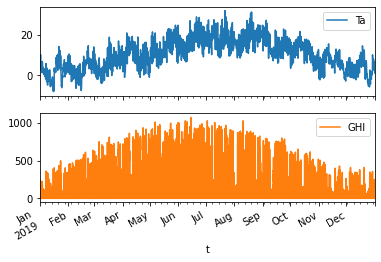

In [50]:
meteo.plot(subplots=True);

We define the plant location and orientation

In [51]:
# location
latitude = 47.03
longitude = 8.296
altitude = 460
location = pvlib.location.Location(latitude, longitude, 'Etc/GMT+1', altitude)

# PV plant
p_module = 300  # potenza del modulo in 300W (1m x 1.7m) (non cambiare)
num_modules = 66  # numero di moduli
tilt = 15
azimuth = 193
albedo = 0.1 # albedo of the ground for ground reflected irradiance

We now calculate the irradiance on the plane of array in the following way:
*   We calculate the sun position based on location and time
*   We split GHI into its direct and diffuse components
*   And project them on the plane of array (POA)

In [52]:
sun_pos = location.get_solarposition(meteo.index)
ghi = meteo['GHI']
dni = pvlib.irradiance.dirint(meteo['GHI'], sun_pos['zenith'], sun_pos.index)
dni.fillna(0, inplace=True)
dhi = ghi - np.cos(np.deg2rad(sun_pos['zenith'])) * dni


irr = pvlib.irradiance.get_total_irradiance(tilt, azimuth, sun_pos['zenith'], sun_pos['azimuth'], dni, ghi, dhi,
                                      albedo=albedo, model_perez='allsitescomposite1990')

We calculate the power of the PV plant with a simplified model that takes into account temperature and inverter efficiency.
We calculate the cell temperature using the [Sandia model](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.temperature.sapm_cell.html), which is based on these two empirical equations:

$$T_{m} = E \cdot \exp (a + b \cdot WS) + T_{a}$$
$$T_{C} = T_{m} + \frac{E}{E_{0}} \Delta T$$

We then correct for module and inverter efficiency as a function of GHI using the following formula:

$$ \eta = k2 + k3 \cdot \log(GHI / GHI_{STC}) +k4 \cdot\log(GHI/GHI_{STC})^2 $$


In [53]:
# correction for angle of incidence using IAM model
b0 = 0.05
aoi = pvlib.irradiance.aoi(tilt, azimuth, sun_pos['zenith'], sun_pos['azimuth'])  # angle of incidence
iam = np.maximum(1 - b0 * (1 / np.cos(np.minimum(np.deg2rad(aoi), np.pi/2)) - 1), 0)
irr['poa_eff'] = iam * irr['poa_direct'] + 0.95 * (irr['poa_diffuse'])

# correction for temperature
gamma = -0.34 / 100  # power loss as function of temperature
t_nom = 25  # nominal temperature
a=-3.56 #
b=-0.075
deltaT=3
wind_speed=1
i_stc = 1000

t_cell = pvlib.temperature.sapm_cell(irr['poa_global'], meteo['Ta'], wind_speed, a, b, deltaT, irrad_ref=i_stc)
irr['poa_eff_tc'] = irr['poa_eff'] * (1 + gamma * (t_bom - t_nom))

# correction for low irrandiance power losses of module and inverter
k2 = 0.942
k3 = -5.02e-2
k4 = -3.77e-2
np.seterr(divide = 'ignore') # disable divide by zero warning 
eta = np.maximum(0.1, (k2 + k3 * np.log(irr['poa_eff'] / i_stc) + k4 * np.log(irr['poa_eff'] / i_stc)**2).fillna(0))
np.seterr(divide = 'warn') 
irr['poa_eff_tc_li'] = irr['poa_eff_tc'] * eta

We calculate the power of the PV plant

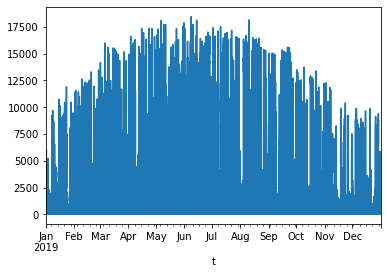

In [54]:
# power of plant in W
p_plant = p_module * irr['poa_eff_tc_li'] / 1000 * num_modules
p_plant.plot()

# calculate the energy of the plant in kWh
e_plant = p_plant / 1000 * (p_plant.index[1]- p_plant.index[0]).seconds / 3600 # W to kWh

# here this is useless
save_path = 'energy_pv.csv'
e_plant.to_csv(save_path, sep=',', date_format='%Y-%m-%dT%H:%M:%S', float_format='%.03f')

# this downloads the csv file onto your local machine
# from google.colab import files
# files.download('energy_pv.csv')

# 2. Consumption data exploration
In the following cells, we dowload the consumption data from the aparments into a pandas dataframe and plot them

In [55]:
!gdown --id 1F8rP6NoZiTUsu9nNEMN3suIhStaSCn78
date_parser = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')
consumption = pd.read_csv('dati_consumo_15min.csv', header=0, parse_dates=[0], date_parser=date_parser, index_col=0)
consumption.head()

Downloading...
From: https://drive.google.com/uc?id=1F8rP6NoZiTUsu9nNEMN3suIhStaSCn78
To: /content/dati_consumo_15min.csv
13.1MB [00:00, 80.0MB/s]


,meter_0001,meter_0002,meter_0003,meter_0004,meter_0005,meter_0006,meter_0007,meter_0008,meter_0009,meter_0010,meter_0011,meter_0012,meter_0013,meter_0014,meter_0015,meter_0016,meter_0017,meter_0018,meter_0019,meter_0020,meter_0021,meter_0022,meter_0023,meter_0024,meter_0025,meter_0026,meter_0027,meter_0028,meter_0029,meter_0030
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:15:00,0.018017,0.020275,0.021447,0.011577,0.009398,0.009164,0.008745,0.007786,0.021154,0.005755,0.007646,0.002050,0.006219,0.006111,0.009846,0.008219,0.009388,0.009332,0.017305,0.012037,0.016487,0.009100,0.018573,0.030718,0.023458,0.024895,0.022042,0.009034,0.018996,0.013450
2019-01-01 00:30:00,0.009959,0.008225,0.012203,0.015851,0.026795,0.017168,0.017885,0.007622,0.010595,0.005710,0.007608,0.007248,0.005999,0.024884,0.006967,0.016333,0.018367,0.020032,0.011123,0.016055,0.007967,0.009185,0.017974,0.028733,0.015230,0.015171,0.012482,0.016341,0.009567,0.038097
2019-01-01 00:45:00,0.009920,0.008091,0.012366,0.017200,0.016013,0.009262,0.008605,0.010487,0.010732,0.005690,0.007613,0.006225,0.005831,0.011522,0.007132,0.008131,0.012162,0.009309,0.017569,0.009485,0.007479,0.009131,0.018131,0.027909,0.015626,0.015120,0.012588,0.040415,0.009668,0.047851
2019-01-01 01:00:00,0.011537,0.008054,0.012329,0.011694,0.009429,0.009246,0.008486,0.014420,0.010446,0.005753,0.007551,0.002113,0.015124,0.006175,0.009709,0.008261,0.009421,0.009473,0.027917,0.009242,0.007439,0.017151,0.036369,0.022211,0.016980,0.019095,0.012292,0.030651,0.009534,0.050035
2019-01-01 01:15:00,0.016851,0.015236,0.022917,0.011671,0.011918,0.009063,0.008548,0.007790,0.013327,0.005644,0.007656,0.002060,0.005878,0.010298,0.014996,0.008230,0.009358,0.009287,0.011161,0.013252,0.011226,0.009225,0.028554,0.022608,0.023549,0.020699,0.022079,0.031388,0.019017,0.048181


Text(0.5, 0, 'total consumption [kWh]')

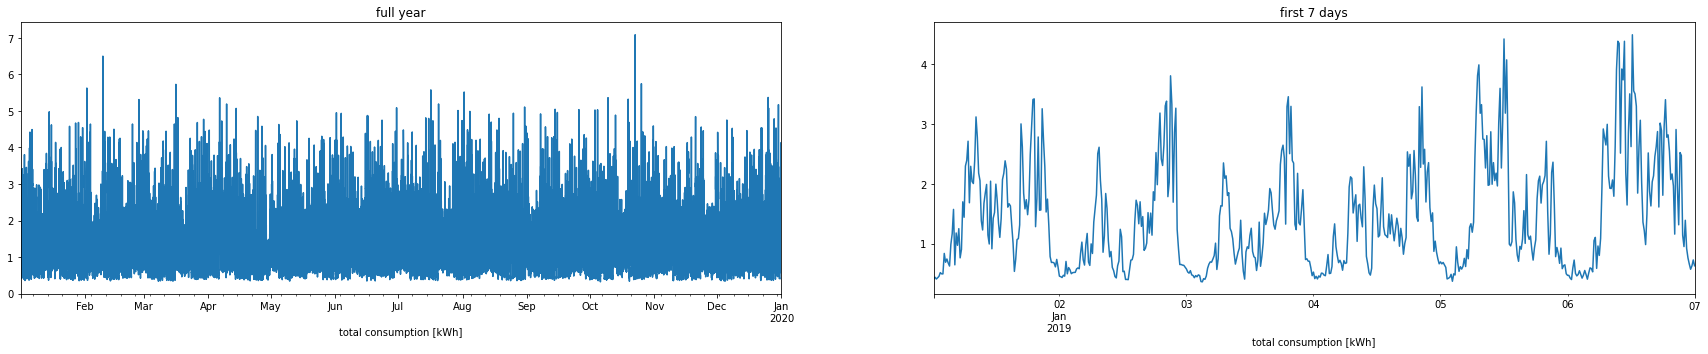

In [56]:
fig, ax = plt.subplots(1,2,figsize=(30,5))
E15 = consumption.sum(axis=1)
E15.plot(ax=ax[0])
ax[0].set_title('full year')
ax[0].set_xlabel('total consumption [kWh]')
E15.iloc[consumption.index<'2019-01-07 00:15:00'].plot(ax=ax[1])
ax[0].set_title('full year')
ax[0].set_xlabel('total consumption [kWh]')
ax[1].set_title('first 7 days')
ax[1].set_xlabel('total consumption [kWh]')

# 3. Return on investment estimate for PV plant
We estimate the return on investment of a PV plant, given:

*   Production profile (calculated above)
*   Cost of the PV plant
*   Operation and maintenance costs
*   Energy prices
*   Self-consumption
*   Cost of capital
*   Expected life of the PV plant

We first install the necessary libraries and define the parameters

In [57]:
%%capture
!pip install numpy_financial
import numpy_financial as npf  # used to calculate financial figures
o_and_m = 30  # operation and maintenace costs [CHF/kW]
wacc = 0.02  # weighted average cost of capital
life_span = 25
degradation = 0.2  # 20% after 25years

self_consumption = 0.6  # 60%
p_sell = 0.06
p_buy = 0.21
p_pv = p_buy * self_consumption + p_sell * (1 - self_consumption)

plant_size = p_module * num_modules / 1000
plant_cost = 34520

$$(1-d)^t = (1-d_m)^{mt}$$
$$d_m = 1-(1-d)^{1/m}$$

In [58]:
e_ls = np.tile(e_plant, (1, life_span))
d_m = 1 - (1-degradation)**(1/len(e_plant))
e_ls *= (1-d_m)**np.arange(len(e_ls))

Let's now perform a very simplistic financial analysis to estimate the return on investment.
First, we calculate all costs and revenues. Then we calculate the free cash flow for the life of the PV system and then calculate the net present value for each year to calculate after how many years we reach a break-even condition. In this very simple analysis, we don't take taxes into account.

##NPV
In economics, the net present value (abbreviated as NPV) is a method used to define the present value of an expected series of cash flows not only by adding them up in the accounts but by discounting them on the basis of the rate of return.
$$\mathrm{NPV}(i, N) = \sum_{t=0}^N \frac{R_t}{(1+i)^t}$$

##IRR
The Internal Rate of Return (IRR) is the rate of the exponential law that makes a financial asset fair.
$$\mathrm{NPV}(IRR, N) = 0$$

Text(0, 0.5, 'CHF')

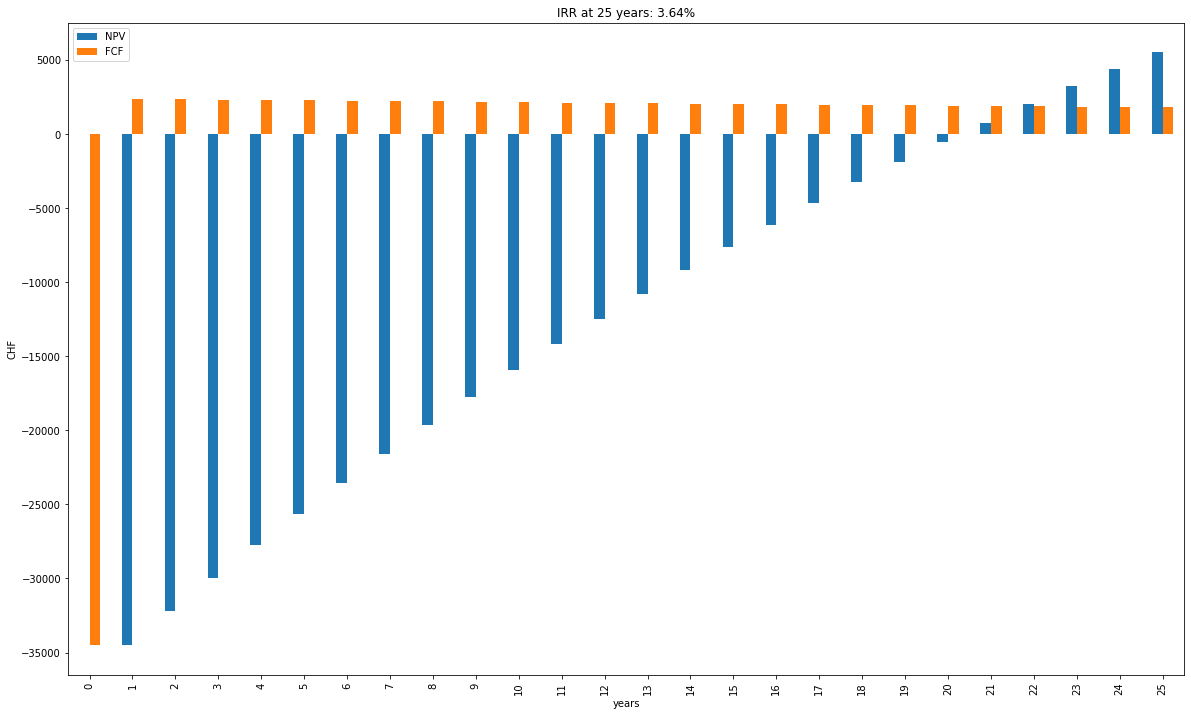

In [59]:
years = range(life_span)
capex = plant_cost
opex = np.ones(life_span) * o_and_m * plant_size
costi = np.hstack([capex, opex])

yearly_production = np.sum(np.reshape(e_25, (life_span, -1)), axis=1)
revenues = yearly_production * p_pv

fcf = np.hstack([0, revenues]) - costi  # free cash flow
npv = np.array([npf.npv(wacc, fcf[:i]) for i in np.arange(life_span + 1)])
irr = npf.irr(fcf)

financials = pd.DataFrame(data={'years': np.arange(26), 'NPV': npv, 'FCF': fcf}).set_index('years')

fig, ax = plt.subplots(1,1,figsize=(20,12))

financials.plot(kind='bar', title='IRR at {} years: {:.2%}'.format(life_span, irr), ax=ax).set_ylabel('CHF')